In [1]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

2025-06-04 15:10:45.124340: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-04 15:10:45.186563: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-04 15:10:45.234535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749021045.279890   21080 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749021045.295381   21080 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-04 15:10:45.393132: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
original_dataset_dir = "/home/amamiya/Desktop/Final-Project-Component/Data"
target_base_dir = "/home/amamiya/Desktop/Final-Project-Component/SplitData"
class_names = ["Daun_Sehat", "Penyakit_Daun_2", "Penyakit_Daun_3"]
samples_per_class = 125
train_count = 100
val_count = 25

def prepare_balanced_split(src_dir, dst_dir):
    os.makedirs(os.path.join(dst_dir, "train"), exist_ok=True)
    os.makedirs(os.path.join(dst_dir, "val"), exist_ok=True)

    for class_name in class_names:
        src_class_dir = os.path.join(src_dir, class_name)
        train_class_dir = os.path.join(dst_dir, "train", class_name)
        val_class_dir = os.path.join(dst_dir, "val", class_name)

        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        all_images = [img for img in os.listdir(src_class_dir) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]
        if len(all_images) < samples_per_class:
            raise ValueError(f"Jumlah gambar di kelas '{class_name}' kurang dari {samples_per_class}")

        random.shuffle(all_images)
        selected_images = all_images[:samples_per_class]

        train_images = selected_images[:train_count]
        val_images = selected_images[train_count:train_count + val_count]

        for img in train_images:
            shutil.copy(os.path.join(src_class_dir, img), os.path.join(train_class_dir, img))
        for img in val_images:
            shutil.copy(os.path.join(src_class_dir, img), os.path.join(val_class_dir, img))

    print("✅ Dataset berhasil diambil sebanyak 125 per kelas dan dibagi ke train (100) & val (25).")

# Eksekusi
prepare_balanced_split(original_dataset_dir, target_base_dir)


✅ Dataset berhasil diambil sebanyak 125 per kelas dan dibagi ke train (100) & val (25).


Found 534 files belonging to 3 classes.
Found 313 files belonging to 3 classes.


2025-06-04 15:10:49.593610: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


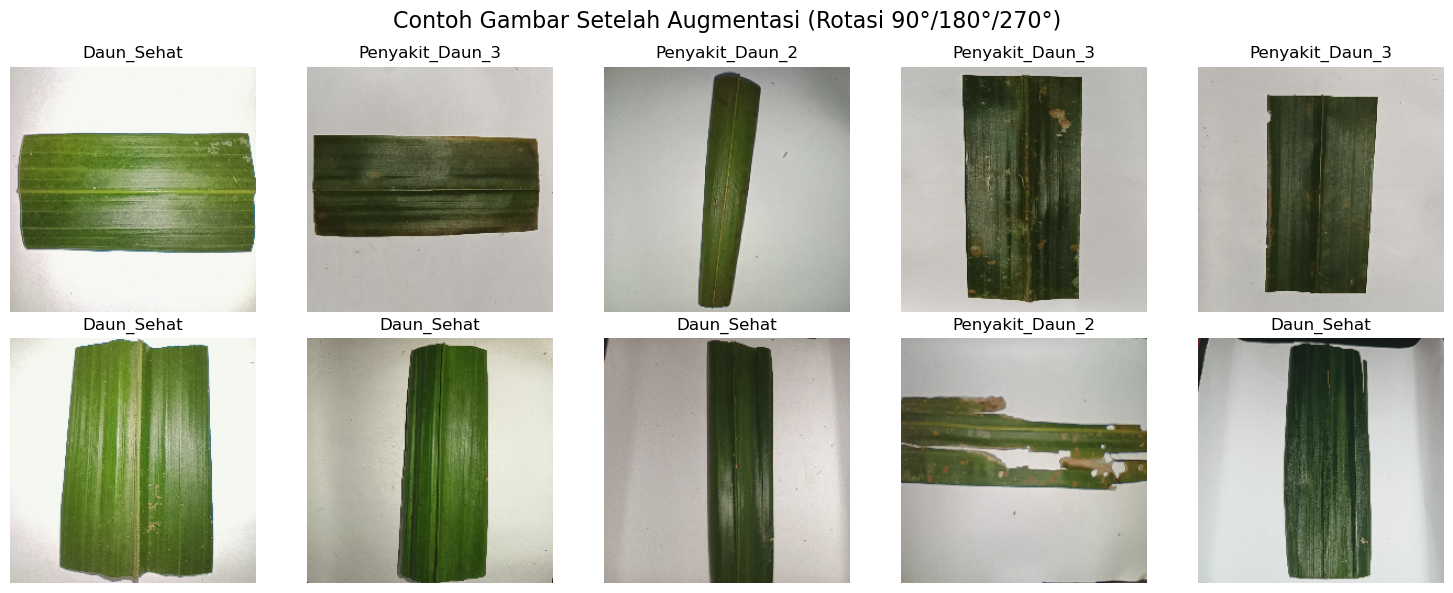

2025-06-04 15:10:50.811581: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
# --- Konfigurasi ---
DATA_DIR = "/home/amamiya/Desktop/Final-Project-Component/SplitData"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

# --- Load dataset ---
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    labels='inferred',
    label_mode='int',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    labels='inferred',
    label_mode='int',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# --- Normalisasi ---
normalization_layer = tf.keras.layers.Rescaling(1./255)

# --- Custom augmentasi: rotasi kelipatan 90 derajat + flip horizontal + kontras + resize ulang ---
@tf.function
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    # Resize ulang supaya ukuran tetap konsisten setelah augmentasi
    return image, label

# --- Pipeline preprocessing ---
def prepare_ds(ds, training=True):
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(tf.data.AUTOTUNE)

train_ds = prepare_ds(train_ds, training=True)
val_ds = prepare_ds(val_ds, training=False)

# --- Visualisasi 10 gambar hasil augmentasi ---
for images, labels in train_ds.take(1):
    plt.figure(figsize=(15, 6))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy())
        label_idx = labels[i].numpy()
        plt.title(class_names[label_idx])
        plt.axis("off")
    plt.suptitle("Contoh Gambar Setelah Augmentasi (Rotasi 90°/180°/270°)", fontsize=16)
    plt.tight_layout()
    plt.show()


In [4]:
# Blok dasar ResNet18 (BasicBlock)
def conv_block(x, filters, kernel_size=3, stride=1, downsample=False):
    shortcut = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if downsample:
        shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

In [5]:
def build_resnet18(input_shape=(224, 224, 3), num_classes=3):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Layer-layer ResNet18 sesuai arsitektur
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    x = conv_block(x, 128, stride=2, downsample=True)
    x = conv_block(x, 128)

    x = conv_block(x, 256, stride=2, downsample=True)
    x = conv_block(x, 256)

    x = conv_block(x, 512, stride=2, downsample=True)
    x = conv_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(3, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
model = build_resnet18(input_shape=(224, 224, 3), num_classes=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,408 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     36,864 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,864 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,864 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,864 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]  

 Total params: 11,187,651 (42.68 MB)

 Trainable params: 11,178,051 (42.64 MB)

 Non-trainable params: 9,600 (37.50 KB)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.6638 - loss: 1.2633 - val_accuracy: 0.3195 - val_loss: 286.5101
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.8903 - loss: 0.3525 - val_accuracy: 0.3930 - val_loss: 19.4224
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.9332 - loss: 0.1870 - val_accuracy: 0.4089 - val_loss: 4.9491
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.9164 - loss: 0.2688 - val_accuracy: 0.3930 - val_loss: 10.8153
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.9296 - loss: 0.2371 - val_accuracy: 0.3930 - val_loss: 12.1452
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.9312 - loss: 0.2469 - val_accuracy: 0.5527 - val_loss: 3.7687
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.9215 - loss: 0.2649 - val_accuracy: 0.4856 - val_loss: 7.3846
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.9404 - loss: 0.2274 - val_accuracy: 0.6454 - va

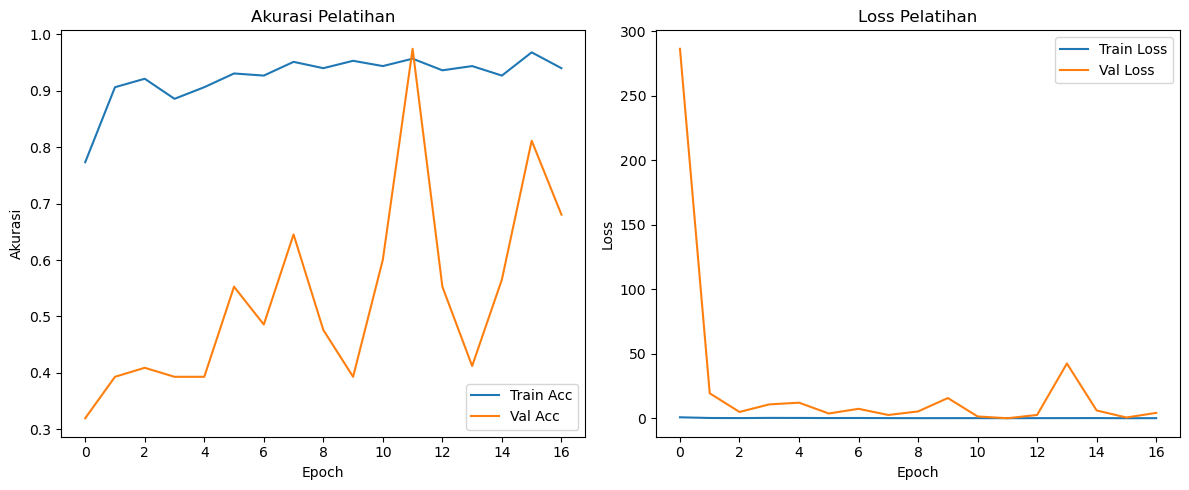

In [7]:
# --- One-hot encode labels (karena pakai categorical_crossentropy) ---
def one_hot_encode(ds, num_classes):
    return ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)), num_parallel_calls=tf.data.AUTOTUNE)

train_ds_encoded = one_hot_encode(train_ds, num_classes=3)
val_ds_encoded = one_hot_encode(val_ds, num_classes=3)

# --- Callback: Simpan model terbaik dan early stopping ---
checkpoint_cb = ModelCheckpoint("model.keras", save_best_only=True, monitor='val_accuracy', mode='max')
earlystop_cb = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy', mode='max')

# --- Latih model ---
history = model.fit(
    train_ds_encoded,
    validation_data=val_ds_encoded,
    epochs=30,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# --- Visualisasi akurasi dan loss ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Akurasi Pelatihan")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Pelatihan")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()